In [1]:
import bmll2 as b2
from bmll2 import reference, Security, NormalisedSecurity, SparkHelper, get_market_data, get_market_data_range, VenueMarketError, get_market_tables, save_spark_dataframe, load_spark_dataframe
b2.get_file('modules/auxiliary_functions.py')

'auxiliary_functions.py'

In [2]:
import auxiliary_functions as af

import random
import math
import pandas as pd
import numpy as np
from pandas import StringDtype
import gc

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LogFormatterSciNotation
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import t

In [3]:
b2.get_file('top_100(Volume)/GFI.csv')
GFI = pd.read_csv('GFI.csv', parse_dates = ['DateTime', 'Date'])
GFI = GFI.rename(columns = {'Ticker' : 'RIC'})
GFI = GFI.sort_values(['DateTime', 'ExchangeSequenceNo'])

b2.get_file('top_100(Volume)/GRT.csv')
GRT = pd.read_csv('GRT.csv', parse_dates = ['DateTime', 'Date'])
GRT = GRT.rename(columns = {'Ticker' : 'RIC'})
GRT = GRT.sort_values(['DateTime', 'ExchangeSequenceNo'])

In [4]:
def impact_df_decay(metaorders_list, timing_method = 'immediate'): 
    
    num_trades = len(metaorders_list)
    
    features = pd.DataFrame(columns = ['RIC', 'Date', 'Start time', 'End time', 'daily volume', 'intraday volatility',
                                       'number child orders', 'volume traded', 'trade sign', 'impact(simple)', 'Mid-price before', 'Mid-price after(immediate)'])
    for i in range(num_trades):
        metaorder = metaorders_list[i]

        if metaorder.empty:
            continue

        intention  = metaorder.iloc[0]['Trade Sign']
        ave_impact = af.impact(metaorder, timing_method = timing_method, impact_method = 'simple')
        n          = metaorder.shape[0]
        volume     = sum(metaorder.loc[:, 'Volume'])

        features.at[i, 'RIC']                       = metaorder['RIC'].iloc[0]
        features.at[i, 'Date']                      = metaorder['Date'].iloc[0]
        features.at[i, 'Start time']                = metaorder['DateTime'].iloc[0]
        features.at[i, 'End time']                  = metaorder['DateTime'].iloc[-1]
        features.at[i, 'daily volume']              = metaorder['Daily Volume'].iloc[0]
        features.at[i, 'intraday volatility']       = metaorder['Daily Volatility'].iloc[0]
        features.at[i, 'number child orders']       = n
        features.at[i, 'volume traded']             = volume
        features.at[i, 'trade sign']                = intention
        features.at[i, 'impact(simple)']            = ave_impact
        features.at[i, 'Mid-price before']          = metaorder['Mid-price before'].iloc[0]
        features.at[i, 'Mid-price after(immediate)'] = metaorder['Mid-price after(immediate)'].iloc[-1]
        

    return features


In [6]:
#b2.get_file('test_data/homo_4_immediate(100).csv')
#impact_data = pd.read_csv('homo_4_immediate(100).csv', parse_dates = ['Date', 'Start time', 'End time'])

b2.get_file('test_data/metaorder_data_homogenous_4.csv')
impact_data = pd.read_csv('metaorder_data_homogenous_4.csv', parse_dates = ['Date', 'Start time', 'End time'])

GRT_AD = impact_data[impact_data['RIC'] == 'GRT'][['RIC', 'Date', '20 AD volatility', '20 AD volume']]
GFI_AD = impact_data[impact_data['RIC'] == 'GFI'][['RIC', 'Date', '20 AD volatility', '20 AD volume']]

GRT_AD = GRT_AD.drop_duplicates(subset = ['Date']).reset_index(drop = True)
GFI_AD = GFI_AD.drop_duplicates(subset = ['Date']).reset_index(drop = True)

del impact_data
gc.collect()

32385

In [6]:
%%time
GRT_mid_prices = get_market_data_range('XJSE', start_date = '2023-01-03', end_date = '2025-12-31',
                                       table_name = 'l1', ticker = 'GRT', df_engine = 'polars',
                                      columns = ['Ticker', 'TradeDate', 'LocalTimestamp', 'BidPrice1', 'BidQuantity1', 'AskPrice1', 'AskQuantity1',
                                                 'ExchangeSequenceNo', 'MarketState'])
GRT_mid_prices = GRT_mid_prices.to_pandas()#toPandas()
GRT_mid_prices = GRT_mid_prices[GRT_mid_prices['MarketState'] == 'CONTINUOUS_TRADING']
GRT_mid_prices = GRT_mid_prices.sort_values(['LocalTimestamp', 'ExchangeSequenceNo'])
GRT_mid_prices['Mid-price'] = (GRT_mid_prices['BidPrice1'] + GRT_mid_prices['AskPrice1']) / 2
GRT_mid_prices.head()

# I can do 3 entire years worth of l1 data at a time for GRT. Takes 60 to load
# I can do 3 entire years worth of l1 data at a time for GFI. Takes 2.5 minutes to load

CPU times: user 26.4 s, sys: 10.9 s, total: 37.3 s
Wall time: 1min 14s


,Ticker,TradeDate,LocalTimestamp,BidPrice1,BidQuantity1,AskPrice1,AskQuantity1,ExchangeSequenceNo,MarketState,Mid-price
3195245,GRT,2023-01-03,2023-01-03 09:00:08.505846,1416.0,1677,1475.0,5000,34311,CONTINUOUS_TRADING,1445.5
3195246,GRT,2023-01-03,2023-01-03 09:00:08.514672,1416.0,1677,1474.0,4066,34316,CONTINUOUS_TRADING,1445.0
3195247,GRT,2023-01-03,2023-01-03 09:00:08.514797,1416.0,1677,1474.0,6766,34320,CONTINUOUS_TRADING,1445.0
3195248,GRT,2023-01-03,2023-01-03 09:00:08.652716,1416.0,1677,1474.0,4066,34422,CONTINUOUS_TRADING,1445.0
3195249,GRT,2023-01-03,2023-01-03 09:00:08.723150,1416.0,1677,1473.0,4074,34445,CONTINUOUS_TRADING,1444.5


In [7]:
%%time
impact_GRT = pd.DataFrame(columns = ['RIC', 'Date', 'Start time', 'End time', 'daily volume', 'intraday volatility',
                                     'number child orders', 'volume traded', 'trade sign','impact(simple)', 'Mid-price before', 
                                     'Mid-price after(immediate)', '20 AD volatility'])
impact_GRT = []
for date, day_D in GRT.groupby('Date', sort = True):
        print(date)

        trades = day_D.loc[day_D['Price'] != 0]
    
        N = 20
        f = af.trader_participation(N = N, method = 'power', alpha = 2, f_min = 1, f_max = trades.shape[0], seed = 1)
        c = af.cumulative_probs(f)

        if trades.empty:
            continue

        output = af.orders(N = N, trades = trades, cumulative_probs = c)
        for n in range(N):
            
            trader_n_trades = trades.iloc[output[n], ]
           
            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)
            
            if len(trader_n_metaorders) < 10:
                continue

            trader_n_features = impact_df_decay(trader_n_metaorders, timing_method = 'immediate')
            trader_n_features['20 AD volatility'] = GRT_AD[GRT_AD['Date'] == date]['20 AD volatility'].iloc[0] 
            trader_n_features['20 AD volume'] = GRT_AD[GRT_AD['Date'] == date]['20 AD volume'].iloc[0]
            
            if not trader_n_features.empty and not trader_n_features.isna().all().all():
                impact_GRT.append(trader_n_features)
                #impact_GRT = pd.concat([impact_GRT, trader_n_features], ignore_index = True)


impact_GRT   = pd.concat(impact_GRT, ignore_index = True)
exclude_cols = ['RIC', 'Date', 'Start time', 'End time']
numeric_cols = [col for col in impact_GRT.columns if col not in exclude_cols]
impact_GRT[numeric_cols] = impact_GRT[numeric_cols].apply(pd.to_numeric, errors = 'coerce')

impact_GRT['Date']          = pd.to_datetime(impact_GRT['Date']).dt.normalize()
impact_GRT['Start time']    = pd.to_datetime(impact_GRT['Start time'], format = 'mixed')
impact_GRT['End time']      = pd.to_datetime(impact_GRT['End time'], format = 'mixed')
impact_GRT['duration(min)'] = (impact_GRT['End time'] - impact_GRT['Start time']).dt.total_seconds() / 60
durations_GRT               = impact_GRT['duration(min)']

#impact_GRT.to_csv('GRT_homo_20_immediate_decay.csv', index = False)
#b2.put_file('GRT_homo_20_immediate_decay.csv', 'test_data')

#impact_GRT.to_csv('GRT_power_4_decay.csv', index = False)
#b2.put_file('GRT_power_4_decay.csv', 'test_data')

impact_GRT.to_csv('GRT_power_20_decay.csv', index = False)
b2.put_file('GRT_power_20_decay.csv', 'test_data')

#impact_GRT.to_csv('GRT_power_10_decay.csv', index = False)
#b2.put_file('GRT_power_10_decay.csv', 'test_data')

# takes about 6 minutes to run

2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-13 00:00:00


In [ ]:
%%time
impact_GFI = pd.DataFrame(columns = ['RIC', 'Date', 'Start time', 'End time', 'daily volume', 'intraday volatility',
                                     'number child orders', 'volume traded', 'trade sign','impact(simple)', 'Mid-price before', 
                                     'Mid-price after(immediate)', '20 AD volatility'])
impact_GFI = []
for date, day_D in GFI.groupby('Date', sort = True):
        print(date)

        trades = day_D.loc[day_D['Price'] != 0]
    
        N = 20
        f = af.trader_participation(N = N, method = 'power', alpha = 2, f_min = 1, f_max = trades.shape[0], seed = 1)
        c = af.cumulative_probs(f)

        if trades.empty:
            continue

        output = af.orders(N = N, trades = trades, cumulative_probs = c)
        for n in range(N):
            
            trader_n_trades = trades.iloc[output[n], ]
           
            if trader_n_trades.empty:
                continue

            trader_n_metaorders = af.metaorders(trader_n_trades)
            
            if len(trader_n_metaorders) < 10:
                continue
        
            trader_n_features = impact_df_decay(trader_n_metaorders, timing_method = 'immediate')
            trader_n_features['20 AD volatility'] = GFI_AD[GFI_AD['Date'] == date]['20 AD volatility'].iloc[0]
            trader_n_features['20 AD volume'] = GFI_AD[GFI_AD['Date'] == date]['20 AD volume'].iloc[0]
            
            if not trader_n_features.empty and not trader_n_features.isna().all().all():
                impact_GFI.append(trader_n_features)
                #impact_GFI = pd.concat([impact_GFI, trader_n_features], ignore_index = True)


impact_GFI   = pd.concat(impact_GFI, ignore_index = True)
exclude_cols = ['RIC', 'Date', 'Start time', 'End time']
numeric_cols = [col for col in impact_GFI.columns if col not in exclude_cols]
impact_GFI[numeric_cols] = impact_GFI[numeric_cols].apply(pd.to_numeric, errors = 'coerce')

impact_GFI['Date']          = pd.to_datetime(impact_GFI['Date']).dt.normalize()
impact_GFI['Start time']    = pd.to_datetime(impact_GFI['Start time'], format = 'mixed')
impact_GFI['End time']      = pd.to_datetime(impact_GFI['End time'], format = 'mixed')
impact_GFI['duration(min)'] = (impact_GFI['End time'] - impact_GFI['Start time']).dt.total_seconds() / 60
durations_GFI               = impact_GFI['duration(min)']

#impact_GFI.to_csv('GFI_homo_20_immediate_decay.csv', index = False)
#b2.put_file('GFI_homo_20_immediate_decay.csv', 'test_data')

#impact_GFI.to_csv('GFI_power_20_decay.csv', index = False)
#b2.put_file('GFI_power_20_decay.csv', 'test_data')

#impact_GFI.to_csv('GFI_power_10_decay.csv', index = False)
#b2.put_file('GFI_power_10_decay.csv', 'test_data')

# takesabout 40 minutes to run

2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-09 00:00:00


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7faca2b6b790>>
Traceback (most recent call last):
  File "/home/bmll/.conda/envs/py311-stable/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00
2023-03-16 00:00:00


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7faca2b6b790>>
Traceback (most recent call last):
  File "/home/bmll/.conda/envs/py311-stable/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


2023-03-17 00:00:00


Start of the processing and plotting for GRT

In [3]:
b2.get_file('test_data/GRT_power_20_decay.csv')
impact_GRT = pd.read_csv('GRT_power_20_decay.csv', parse_dates = ['Date', 'Start time', 'End time'])

In [9]:
impact_GRT.head()

,RIC,Date,Start time,End time,daily volume,intraday volatility,number child orders,volume traded,trade sign,impact(simple),Mid-price before,Mid-price after(immediate),20 AD volatility,20 AD volume,duration(min)
0,GRT,2023-01-03,2023-01-03 09:13:38.766784,2023-01-03 10:16:22.490396,6862853.0,0.035155,8,29241.0,-1,-0.002761,1447.0,1451.0,0.035155,6862853.0,62.728727
1,GRT,2023-01-03,2023-01-03 10:17:42.940561,2023-01-03 10:24:35.100951,6862853.0,0.035155,4,1771.0,-1,-0.001033,1452.0,1453.5,0.035155,6862853.0,6.869340
2,GRT,2023-01-03,2023-01-03 10:35:31.100290,2023-01-03 10:35:34.309615,6862853.0,0.035155,3,4222.0,-1,-0.000000,1456.0,1456.0,0.035155,6862853.0,0.053489
3,GRT,2023-01-03,2023-01-03 10:35:50.436098,2023-01-03 10:39:38.217363,6862853.0,0.035155,2,6646.0,1,0.000687,1456.0,1457.0,0.035155,6862853.0,3.796354
4,GRT,2023-01-03,2023-01-03 10:39:39.660790,2023-01-03 10:39:45.396306,6862853.0,0.035155,3,9407.0,-1,0.001030,1457.0,1455.5,0.035155,6862853.0,0.095592


In [10]:
GRT_mid_prices = get_market_data_range('XJSE', start_date = '2023-01-03', end_date = '2025-12-31',
                                       table_name = 'l1', ticker = 'GRT', df_engine = 'polars',
                                      columns = ['Ticker', 'TradeDate', 'EventTimestamp', 'LocalTimestamp', 'BidPrice1', 'BidQuantity1', 'AskPrice1',
                                                 'AskQuantity1', 'ExchangeSequenceNo', 'MarketState'])
GRT_mid_prices = GRT_mid_prices.to_pandas()#toPandas()
GRT_mid_prices = GRT_mid_prices[GRT_mid_prices['MarketState'] == 'CONTINUOUS_TRADING']
GRT_mid_prices = GRT_mid_prices.sort_values(['LocalTimestamp', 'ExchangeSequenceNo'])
GRT_mid_prices['Mid-price'] = (GRT_mid_prices['BidPrice1'] + GRT_mid_prices['AskPrice1']) / 2
GRT_mid_prices.head()

,Ticker,TradeDate,EventTimestamp,LocalTimestamp,BidPrice1,BidQuantity1,AskPrice1,AskQuantity1,ExchangeSequenceNo,MarketState,Mid-price
3195245,GRT,2023-01-03,2023-01-03 07:00:08.505846,2023-01-03 09:00:08.505846,1416.0,1677,1475.0,5000,34311,CONTINUOUS_TRADING,1445.5
3195246,GRT,2023-01-03,2023-01-03 07:00:08.514672,2023-01-03 09:00:08.514672,1416.0,1677,1474.0,4066,34316,CONTINUOUS_TRADING,1445.0
3195247,GRT,2023-01-03,2023-01-03 07:00:08.514797,2023-01-03 09:00:08.514797,1416.0,1677,1474.0,6766,34320,CONTINUOUS_TRADING,1445.0
3195248,GRT,2023-01-03,2023-01-03 07:00:08.652716,2023-01-03 09:00:08.652716,1416.0,1677,1474.0,4066,34422,CONTINUOUS_TRADING,1445.0
3195249,GRT,2023-01-03,2023-01-03 07:00:08.723150,2023-01-03 09:00:08.723150,1416.0,1677,1473.0,4074,34445,CONTINUOUS_TRADING,1444.5


In [ ]:
%%time

decay_df = []

z_max = 2
z_grid = np.linspace(1, z_max, 200)

for date, day_D in impact_GRT.groupby('Date', sort = True):

    print(date)
    day_D = day_D.sort_values(['Start time'])
    num_metaorders = day_D.shape[0]

    for i in range(num_metaorders):

        if impact_GRT['number child orders'].iloc[i] < 10:
            continue

        else:
            delta_t = pd.to_timedelta(z_grid * impact_GRT['duration(min)'].iloc[i], unit = 'min')
            t_grid  = impact_GRT['Start time'].iloc[i] + delta_t
    
            grid_df = pd.DataFrame({'query time': t_grid.astype('datetime64[us]'), 
                                    'z': z_grid}).sort_values('query time')
            
            candidate_df = GRT_mid_prices[(GRT_mid_prices['LocalTimestamp'] >= grid_df['query time'].iloc[0]) & 
                                          (GRT_mid_prices['LocalTimestamp'] <= grid_df['query time'].iloc[-1])]
            merged = pd.merge_asof(grid_df, candidate_df, right_on = 'LocalTimestamp', left_on = 'query time', direction = 'backward', allow_exact_matches = True)
            merged = merged.dropna(subset = ['BidPrice1', 'AskPrice1'])
    
            mid_prices_array     = np.full(merged.shape[0] + 2, np.nan)
            mid_prices_array[0]  = impact_GRT['Mid-price before'].iloc[i]
            mid_prices_array[1]  = impact_GRT['Mid-price after(immediate)'].iloc[i]
            mid_prices_array[2:] = merged['Mid-price']
    
            z                    = np.full(merged.shape[0] + 2, np.nan)
            z[0]                 = 0
            z[1]                 = 1
            z[2:]                = merged['z']
            
            Q                    = impact_GRT['volume traded'].iloc[i]
            sigma                = impact_GRT['20 AD volatility'].iloc[i]
            volume               = impact_GRT['20 AD volume'].iloc[i] 
            impact               = impact_GRT['trade sign'].iloc[i] * (np.log(mid_prices_array) - np.log(mid_prices_array[0]))
            scaled_impact_decay  = impact_GRT['trade sign'].iloc[i] * (np.log(mid_prices_array) - np.log(mid_prices_array[0])) / (np.sqrt(Q) * sigma)
            scaled_impact_decay_vol  = impact_GRT['trade sign'].iloc[i] * (np.log(mid_prices_array) - np.log(mid_prices_array[0])) / (np.sqrt(Q / volume) * sigma)
    
            decay_df_day = pd.DataFrame({'Date': date, 'z': z, 'Q': Q, 'sigma': sigma, 'impact': impact, 'scaled impact': scaled_impact_decay,
                                         'scaled impact(with volume)': scaled_impact_decay_vol})
            decay_df.append(decay_df_day)
        
decay_df = pd.concat(decay_df, ignore_index = True)


decay_df.to_csv('GRT_impact_profile(post)_power_20.csv', index = False)
b2.put_file('GRT_impact_profile(post)_power_20.csv', 'test_data')        

# takes about 8 minutes

Decay processing for GFI starts here

In [30]:
b2.get_file('test_data/GFI_power_20_decay.csv')
impact_GFI = pd.read_csv('GFI_power_20_decay.csv', parse_dates = ['Date', 'Start time', 'End time'])

In [7]:
%%time
GFI_mid_prices = get_market_data_range('XJSE', start_date = '2023-01-03', end_date = '2025-12-31',
                                       table_name = 'l1', ticker = 'GFI', df_engine = 'polars',
                                      columns = ['Ticker', 'TradeDate', 'LocalTimestamp', 'BidPrice1', 'BidQuantity1', 'AskPrice1', 'AskQuantity1',
                                                 'ExchangeSequenceNo', 'MarketState'])
GFI_mid_prices = GFI_mid_prices.to_pandas()#toPandas()
GFI_mid_prices = GFI_mid_prices[GFI_mid_prices['MarketState'] == 'CONTINUOUS_TRADING']
GFI_mid_prices = GFI_mid_prices.sort_values(['LocalTimestamp', 'ExchangeSequenceNo'])
GFI_mid_prices['Mid-price'] = (GFI_mid_prices['BidPrice1'] + GFI_mid_prices['AskPrice1']) / 2
GFI_mid_prices.head()    

CPU times: user 1min 37s, sys: 31.1 s, total: 2min 8s
Wall time: 2min


,Ticker,TradeDate,LocalTimestamp,BidPrice1,BidQuantity1,AskPrice1,AskQuantity1,ExchangeSequenceNo,MarketState,Mid-price
60672849,GFI,2023-01-03,2023-01-03 09:00:17.338527,17800.0,4,17979.0,308,37359,CONTINUOUS_TRADING,17889.5
60672850,GFI,2023-01-03,2023-01-03 09:00:17.553216,17800.0,392,17979.0,308,37475,CONTINUOUS_TRADING,17889.5
60672851,GFI,2023-01-03,2023-01-03 09:00:17.553323,17801.0,316,17979.0,308,37476,CONTINUOUS_TRADING,17890.0
60672852,GFI,2023-01-03,2023-01-03 09:00:17.553417,17801.0,416,17979.0,308,37480,CONTINUOUS_TRADING,17890.0
60672853,GFI,2023-01-03,2023-01-03 09:00:17.559032,17801.0,416,17979.0,490,37485,CONTINUOUS_TRADING,17890.0


In [11]:
%%time
decay_df = []  

z_max = 2
z_grid = np.linspace(1, z_max, 100)

for date, day_D in impact_GFI.groupby('Date', sort = True):

    print(date)
    
    day_D = day_D.sort_values(['Start time'])
    num_metaorders = day_D.shape[0]

    for i in range(num_metaorders):

        if impact_GFI['number child orders'].iloc[i] < 10:
            continue

        else:
            delta_t = pd.to_timedelta(z_grid * impact_GFI['duration(min)'].iloc[i], unit = 'min')
            t_grid  = impact_GFI['Start time'].iloc[i] + delta_t
    
            grid_df = pd.DataFrame({'query time': t_grid.astype('datetime64[us]'), 
                                    'z': z_grid}).sort_values('query time')
            
            candidate_df = GFI_mid_prices[(GFI_mid_prices['LocalTimestamp'] >= grid_df['query time'].iloc[0]) & 
                                          (GFI_mid_prices['LocalTimestamp'] <= grid_df['query time'].iloc[-1])]
            merged = pd.merge_asof(grid_df, candidate_df, right_on = 'LocalTimestamp', left_on = 'query time', direction = 'backward', allow_exact_matches = True)
            merged = merged.dropna(subset = ['BidPrice1', 'AskPrice1'])
    
            mid_prices_array     = np.full(merged.shape[0] + 2, np.nan)
            mid_prices_array[0]  = impact_GFI['Mid-price before'].iloc[i]
            mid_prices_array[1]  = impact_GFI['Mid-price after(immediate)'].iloc[i]
            mid_prices_array[2:] = merged['Mid-price']
    
            z                    = np.full(merged.shape[0] + 2, np.nan)
            z[0]                 = 0
            z[1]                 = 1
            z[2:]                = merged['z']
            
            Q                    = impact_GFI['volume traded'].iloc[i]
            sigma                = impact_GFI['20 AD volatility'].iloc[i]
            volume               = impact_GFI['20 AD volume'].iloc[i]
            impact               = impact_GFI['trade sign'].iloc[i] * (np.log(mid_prices_array) - np.log(mid_prices_array[0]))
            scaled_impact_decay  = impact_GFI['trade sign'].iloc[i] * (np.log(mid_prices_array) - np.log(mid_prices_array[0])) / (np.sqrt(Q) * sigma)
            scaled_impact_decay_volume  = impact_GFI['trade sign'].iloc[i] * (np.log(mid_prices_array) - np.log(mid_prices_array[0])) / (np.sqrt(Q / volume) * sigma)
    
            decay_df_day = pd.DataFrame({'Date': date, 'z': z, 'Q': Q, 'sigma': sigma, 'impact': impact, 'scaled impact': scaled_impact_decay,
                                         'scaled impact(with volume)': scaled_impact_decay_vol})
            decay_df.append(decay_df_day)
        
decay_df = pd.concat(decay_df, ignore_index = True)
decay_df.to_csv('GFI_impact_profile(post)_power_10.csv', index = False)
b2.put_file('GFI_impact_profile(post)_power_10.csv', 'test_data')

# takes about 5 hours 

2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00
2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-13 00:00:00


In [31]:
b2.get_file('test_data/GFI_impact_profile(post)_power_20.csv')
GFI_decay = pd.read_csv('GFI_impact_profile(post)_power_20.csv')
GFI_decay.head()

,Date,z,Q,sigma,scaled impact
0,2023-01-03,0.000000,1981.0,0.042035,-0.000000
1,2023-01-03,1.000000,1981.0,0.042035,0.001966
2,2023-01-03,1.000000,1981.0,0.042035,0.001937
3,2023-01-03,1.010101,1981.0,0.042035,0.002160
4,2023-01-03,1.020202,1981.0,0.042035,0.001907


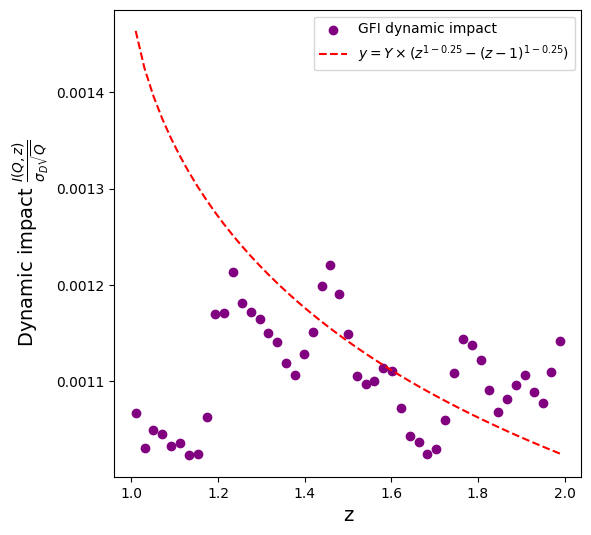

In [10]:
# best so far when using a power law and 20, only more than 10 child orders
bins = np.linspace(1, 2, 50)
z_bins_GFI = pd.cut(GFI_decay['z'], bins = bins)

dynamic_impact_bins_vals_GFI = GFI_decay['scaled impact'].groupby(z_bins_GFI, observed = False).mean()
z_bins_centers_GFI           = [interval.mid for interval in dynamic_impact_bins_vals_GFI.index.categories]
z_bins_centers_GFI = np.array(z_bins_centers_GFI)
beta = 0.25
convex_line_GFI = 0.0015 * (z_bins_centers_GFI ** (1 - beta) - (z_bins_centers_GFI - 1) ** (1 - beta))
straight_line_GFI = - 0.00014 * z_bins_centers_GFI + 0.0006

fig, ax = plt.subplots(figsize = (6, 6))

ax.scatter(z_bins_centers_GFI, dynamic_impact_bins_vals_GFI, color = 'purple', marker = 'o', label = 'GFI dynamic impact')
ax.plot(z_bins_centers_GFI, convex_line_GFI, color = 'red', linestyle = '--', label = rf'$y = Y\times\left(z^{{1-{beta}}} - \left(z-1\right)^{{1-{beta}}}\right)$')
#ax.plot(z_bins_centers_GFI, straight_line_GFI, color = 'black', linestyle = '--', label = r'$y = Y\left(z^{1-\beta} - \left(z-1\right)^{1-\beta}\right$')
ax.set_xlabel(r'z', fontsize = 14)
ax.set_ylabel(r'Dynamic impact $\frac{I(Q, z)}{\sigma_{D} \sqrt{Q}}$', fontsize = 14)
#ax.plot(phi_bins_centers_GFI, concave_line_GFI, color = 'red', linestyle = '--', label = r'y = Y$\sqrt{\phi}$')
#ax.plot(phi_bins_centers_GFI, straight_line_GFI, color = 'black', linestyle = '--', label = r'y = Y$\phi$')
ax.legend()

ax.set_box_aspect(1)
plt.tight_layout()

#plt.savefig('convex_profile_GFI(20ADV).pdf')
#b2.put_file('convex_profile_GFI(20ADV).pdf', 'figures')
#b2.get_file('figures/convex_profile_GFI(20ADV).pdf')

plt.show()